In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("C:/Users/webde/Downloads/canada.xlsx",
                  names = ['year','pop_millions','gdp_millions','lifeExpectancy','lowIncome'])
# basic checks
print("Dataframe shape: ", df.shape)
print("Dataframe columns: ", df.columns)
if 'year' not in df.columns:
  raise KeyError("Expect 'year' a column")

cols = ['pop_millions','gdp_millions','lifeExpectancy','lowIncome']
for c in cols:
  df[c] = pd.to_numeric(df[c], errors ='coerce')
# compute percapita ensuring we don't have zero division
df['percapita']=np.where(df['pop_millions']>0,
                        (df['gdp_millions']/df['pop_millions']).round(2),np.nan)
# make 'year' an index
df = df.set_index('year').sort_index()
df.head(10)

Dataframe shape:  (65, 5)
Dataframe columns:  Index(['year', 'pop_millions', 'gdp_millions', 'lifeExpectancy', 'lowIncome'], dtype='object')


,pop_millions,gdp_millions,lifeExpectancy,lowIncome,percapita
year,,,,,
1960,17.98,40265,71.1,0.145,2239.43
1961,18.27,42026,71.2,0.143,2300.27
1962,18.61,45739,71.4,0.140,2457.76
1963,18.96,49273,71.4,0.141,2598.79
1964,19.33,53975,71.8,0.138,2792.29
1965,19.68,59551,71.9,0.143,3025.97
1966,20.05,66705,72.0,0.140,3326.93
1967,20.41,71812,72.2,0.135,3518.47
1968,20.74,78474,72.4,0.136,3783.70


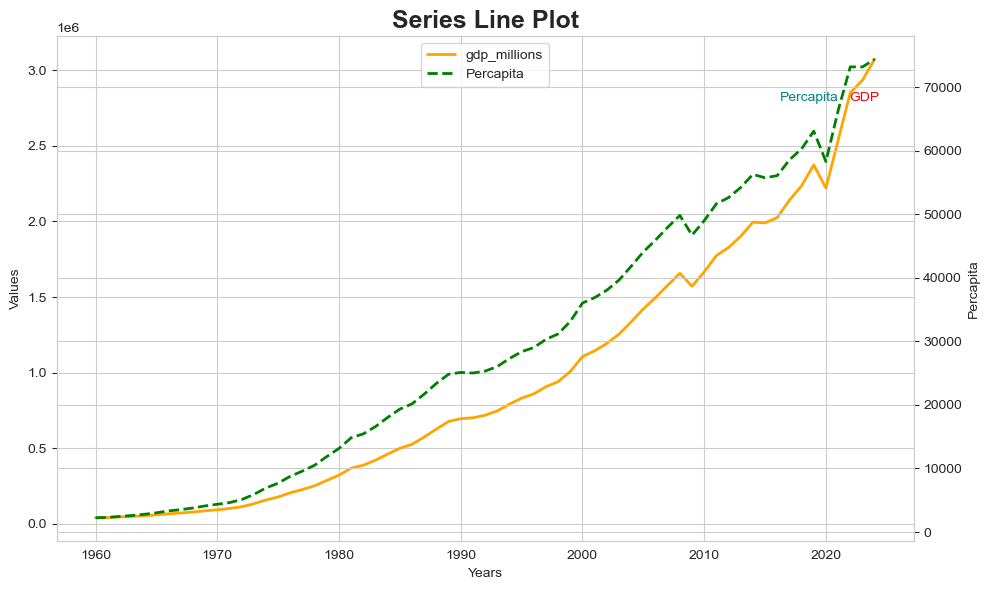

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
primary_cols = ['gdp_millions']
df[primary_cols].plot(ax=ax, color='orange',lw=2)
ax2 = ax.twinx()
df['percapita'].plot(ax=ax2,color='g',linestyle='--',lw=2,label='Percapita')
# titles and labesl
ax.set_title("Series Line Plot", fontsize=18, fontweight='bold')
ax.set_xlabel("Years")
ax.set_ylabel("Values")
ax2.set_ylabel("Percapita")
# unified legend
handles,labels = ax.get_legend_handles_labels()
handles2,labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles+handles2,labels+labels2, loc='upper center')
# annotations
ax2.annotate('Percapita', xy=(df.index[-1],df['percapita'].iloc[-1]),xytext=(-68,-30),
            textcoords='offset points',color='teal')
ax.annotate('GDP', xy=(df.index[-1], df['gdp_millions'].iloc[-1]),xytext=(-18,-30),
            textcoords='offset points',color='red')
ax.legend().remove()
plt.tight_layout()
plt.show()

In [4]:
import statsmodels.formula.api as smf
formula = 'percapita~gdp_millions+lifeExpectancy'
reg = smf.ols(formula, data=df).fit()
print("---------- Regression Results ---------")
display(reg.summary())


---------- Regression Results ---------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              percapita   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.725e+04
Date:                Mon, 05 Jan 2026   Prob (F-statistic):           5.27e-92
Time:                        17:07:00   Log-Likelihood:                -520.60
No. Observations:                  65   AIC:                             1047.
Df Residuals:                      62   BIC:                             1054.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.324e+05   4815.685    -27.485      0.000   -1.42e+05   -1.23e+05
gdp_millions       0.0181      0.000     64.785      0.000       0.018       0.019
lifeExpectancy  1866.0125     65.506     28.486      0.000    1735.068    1996.957
==============================================================================
Omnibus:                        1.971   Durbin-Watson:                   0.731
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.895
Skew:                           0.400   Prob(JB):                        0.388
Kurtosis:                       2.754   Cond. No.                     6.67e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.67e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
# metrics and diagnostics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
X = df[['gdp_millions','lifeExpectancy']]
y = df['percapita']

model = LinearRegression()
model.fit(X,y)

y_pred = model.predict(X)
render_table = pd.DataFrame({
	'Actual Percapita': y,
 'Predicted Percapita': y_pred,
 'Error(%)': 100*((y_pred - y)/y)
})
all = render_table.sort_values('Actual Percapita')
display(round(all,2))

,Actual Percapita,Predicted Percapita,Error(%)
year,,,
1960,2239.43,1045.08,-53.33
1961,2300.27,1263.56,-45.07
1962,2457.76,1703.98,-30.67
1963,2598.79,1767.96,-31.97
1964,2792.29,2599.49,-6.90
...,...,...,...
2019,63093.12,63998.08,1.43
2021,66313.23,65069.41,-1.88
2023,73198.85,73207.36,0.01


In [6]:
r2 = r2_score(y, y_pred)
actual_mean = y.mean()
mae = mean_absolute_error(y, y_pred)
weighted_mean = 100*(mae/actual_mean)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
residuals = y - y_pred
abs_error = np.abs(residuals)

# display the metrics
print(f"R-Squared: {r2:.3f}")
print(f"Actual Mean Percapita: ${actual_mean:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.3f}")
print(f"Weighted MAE (% of Mean): {weighted_mean:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.3f}")

R-Squared: 0.999
Actual Mean Percapita: $29295.52
Mean Absolute Error (MAE): $587.000
Weighted MAE (% of Mean): 2.00
Root Mean Squared Error (RMSE): $728.013


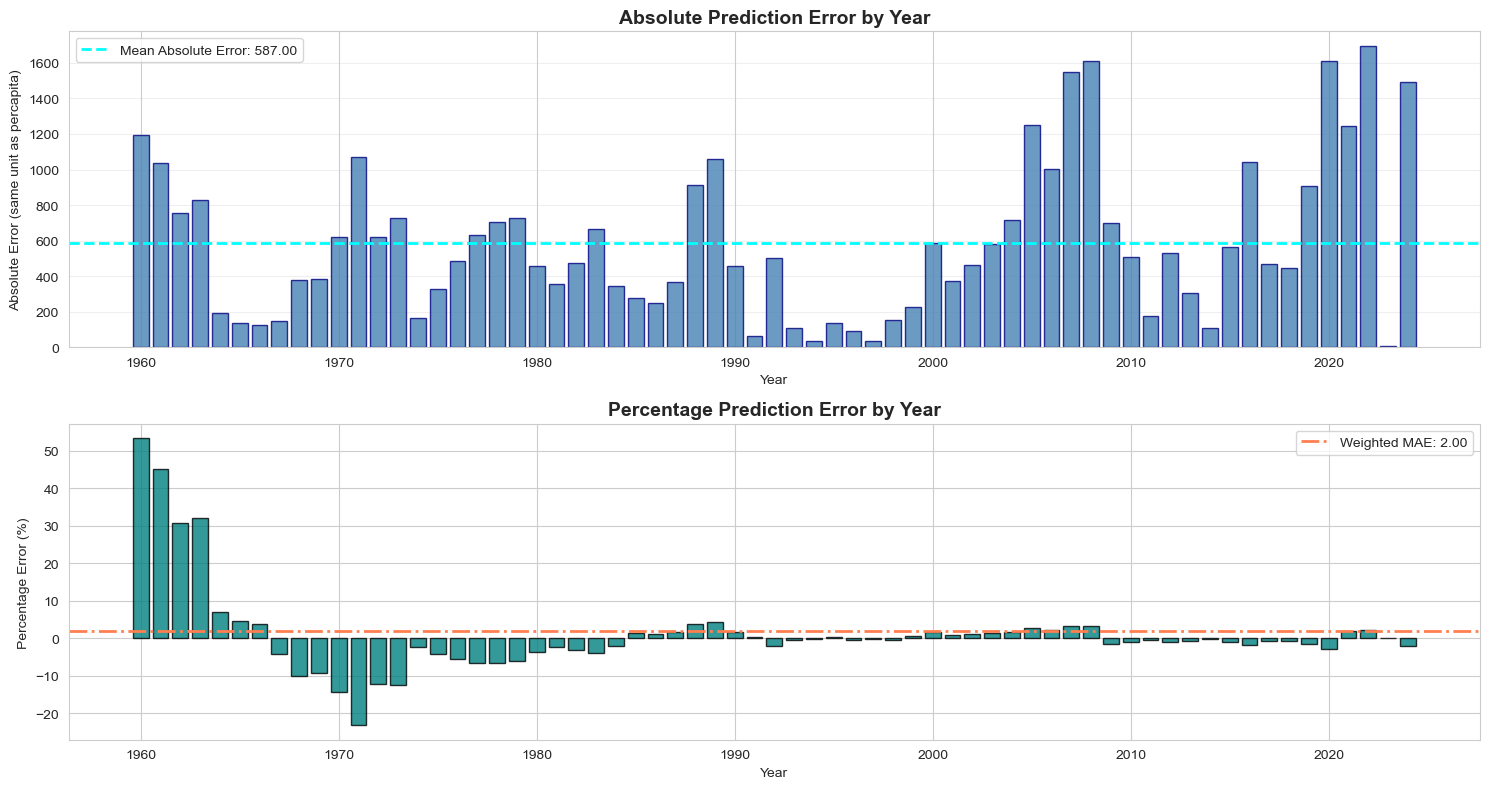

In [7]:
# Prediction Error Analysis by Year
fig, axes = plt.subplots(2,1,figsize=(15,8))
# Absolute Mean Error by Year
years = y.index
pct_error = 100*(residuals/y)
axes[0].bar(years, abs_error, color='steelblue',alpha=0.8, edgecolor='navy')
axes[0].set_title('Absolute Prediction Error by Year', fontsize=14,fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Absolute Error (same unit as percapita)')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(mae, color='aqua',linestyle='--',lw=2,label=f"Mean Absolute Error: {mae:.2f}")
axes[0].legend()
# Percentage Error by Year
axes[1].bar(years, pct_error, color='teal',alpha=0.8,edgecolor='black')
axes[1].set_title('Percentage Prediction Error by Year', fontsize=14,fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage Error (%)')
axes[1].axhline(weighted_mean, color='coral',linestyle='-.',lw=2,label=f"Weighted MAE: {weighted_mean:.2f}")
axes[1].legend()
plt.tight_layout()
plt.show()




In [8]:
weighted_mean = 100*(mae/actual_mean)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(((y_pred - y)/y)**2))*100

print(f"Weighted MAE (% of Mean): {weighted_mean:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.3f}")
print(f"RMSPE (%): {rmspe:.2f}%")

Weighted MAE (% of Mean): 2.00
Root Mean Squared Error (RMSE): $728.013
RMSPE (%): 11.45%


In [9]:
y_pred = model.predict(X)
render_table = pd.DataFrame({
	'Actual Percapita': y,
 'Predicted Percapita': y_pred,
 'Error(%)': 100*((y_pred - y)/y)
})
all = render_table.sort_values('Actual Percapita')
display(round(all,2))
# largest bad predictions
render_table['AbsError(%)'] = render_table['Error(%)'].abs()
display(round(render_table.nlargest(10, 'AbsError(%)')),2)

,Actual Percapita,Predicted Percapita,Error(%)
year,,,
1960,2239.43,1045.08,-53.33
1961,2300.27,1263.56,-45.07
1962,2457.76,1703.98,-30.67
1963,2598.79,1767.96,-31.97
1964,2792.29,2599.49,-6.90
...,...,...,...
2019,63093.12,63998.08,1.43
2021,66313.23,65069.41,-1.88
2023,73198.85,73207.36,0.01


,Actual Percapita,Predicted Percapita,Error(%),AbsError(%)
year,,,,
1960,2239.0,1045.0,-53.0,53.0
1961,2300.0,1264.0,-45.0,45.0
1963,2599.0,1768.0,-32.0,32.0
1962,2458.0,1704.0,-31.0,31.0
1971,4630.0,5702.0,23.0,23.0
1970,4369.0,4988.0,14.0,14.0
1973,5912.0,6642.0,12.0,12.0
1972,5109.0,5730.0,12.0,12.0
1968,3784.0,4163.0,10.0,10.0


2